# Titanic Dataset: Predicting Survivability

## Plan of Attack

## Import Libraries

In [943]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')


## Custom Functions

In [944]:
def concat_df(train, test):
    return pd.concat([train, test], sort=True).reset_index(drop=True)

def separate_df(train_test):
    return train_test[:890], train_test[891:].drop(['Survived'], axis=1)

## Import Datasets

In [945]:
train = pd.read_csv('datasets/titanic_train.csv')
test = pd.read_csv('datasets/titanic_test.csv')

## Missing Data

In [946]:
train_test = concat_df(train, test)
train_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1046 non-null   float64
 1   Cabin        295 non-null    object 
 2   Embarked     1307 non-null   object 
 3   Fare         1308 non-null   float64
 4   Name         1309 non-null   object 
 5   Parch        1309 non-null   int64  
 6   PassengerId  1309 non-null   int64  
 7   Pclass       1309 non-null   int64  
 8   Sex          1309 non-null   object 
 9   SibSp        1309 non-null   int64  
 10  Survived     891 non-null    float64
 11  Ticket       1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


### Age

In [947]:
train_test.corr().abs()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
Age,1.000000,0.178740,0.150917,0.028814,0.408106,0.243699,0.077221
Fare,0.178740,1.000000,0.221539,0.031428,0.558629,0.160238,0.257307
Parch,0.150917,0.221539,1.000000,0.008942,0.018322,0.373587,0.081629
PassengerId,0.028814,0.031428,0.008942,1.000000,0.038354,0.055224,0.005007
Pclass,0.408106,0.558629,0.018322,0.038354,1.000000,0.060832,0.338481
SibSp,0.243699,0.160238,0.373587,0.055224,0.060832,1.000000,0.035322
Survived,0.077221,0.257307,0.081629,0.005007,0.338481,0.035322,1.000000


In [948]:
train_test['Age'] = train_test.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

### Cabin

In [949]:
train_test.drop(['Cabin'], axis=1, inplace=True)

### Embarked

In [950]:
train_test[train_test['Embarked'].isnull()]

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [951]:
train_test['Embarked']=train_test['Embarked'].fillna('S')

### Fare

In [952]:
train_test[train_test['Fare'].isnull()]

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [953]:
train_test['Fare'] = train_test['Fare'].fillna(train_test.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0])

In [954]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1309 non-null   float64
 1   Embarked     1309 non-null   object 
 2   Fare         1309 non-null   float64
 3   Name         1309 non-null   object 
 4   Parch        1309 non-null   int64  
 5   PassengerId  1309 non-null   int64  
 6   Pclass       1309 non-null   int64  
 7   Sex          1309 non-null   object 
 8   SibSp        1309 non-null   int64  
 9   Survived     891 non-null    float64
 10  Ticket       1309 non-null   object 
dtypes: float64(3), int64(4), object(4)
memory usage: 112.6+ KB


## Feature Engineering

### Binning Fares Together

In [955]:
train_test['Fare'] = pd.qcut(train_test['Fare'], 10)

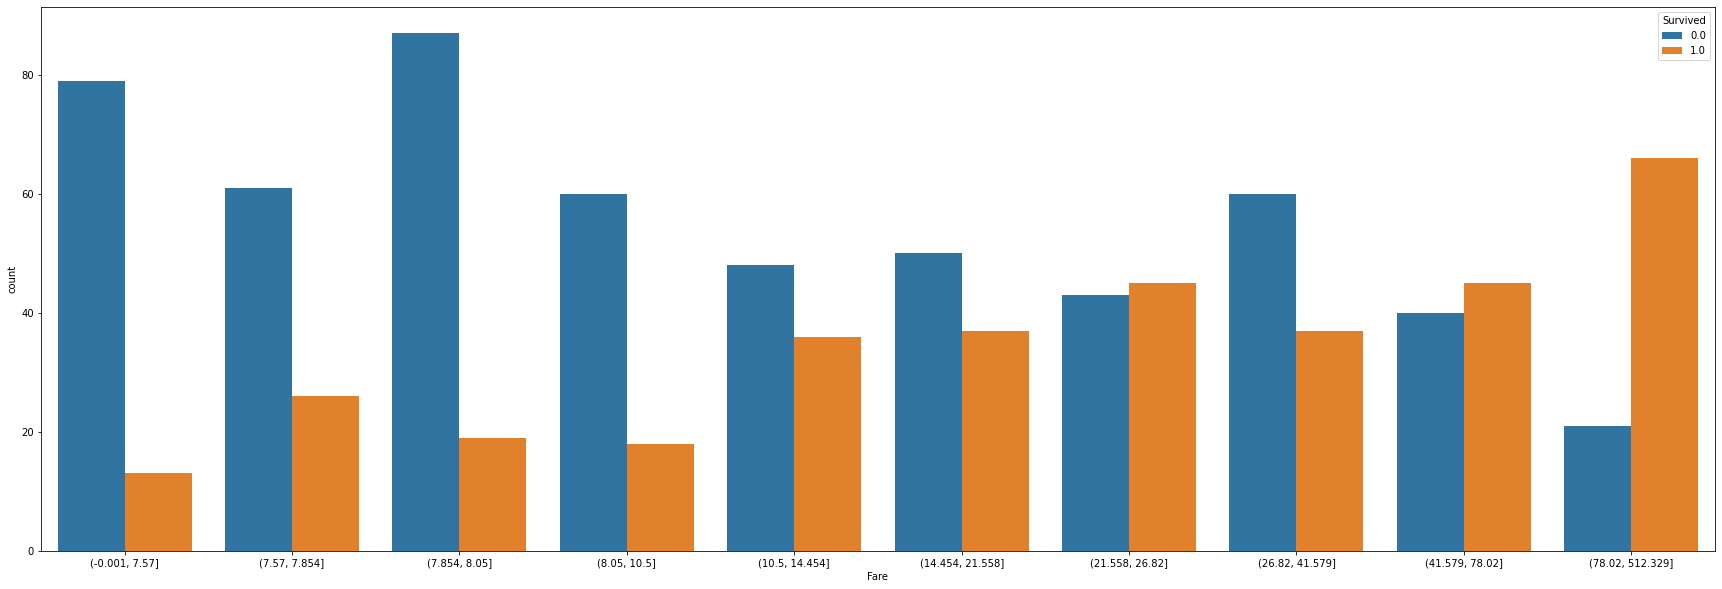

In [956]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize=(30,10))
sns.countplot(x='Fare', hue='Survived', data=train_test)
plt.show()

In [957]:
train_test.Fare.unique()

[(-0.001, 7.57], (41.579, 78.02], (7.854, 8.05], (8.05, 10.5], (14.454, 21.558], (10.5, 14.454], (26.82, 41.579], (21.558, 26.82], (7.57, 7.854], (78.02, 512.329]]
Categories (10, interval[float64, right]): [(-0.001, 7.57] < (7.57, 7.854] < (7.854, 8.05] < (8.05, 10.5] ... (21.558, 26.82] < (26.82, 41.579] < (41.579, 78.02] < (78.02, 512.329]]

### Binning Ages Together

In [958]:
train_test['Age'] = pd.qcut(train_test['Age'], 10)

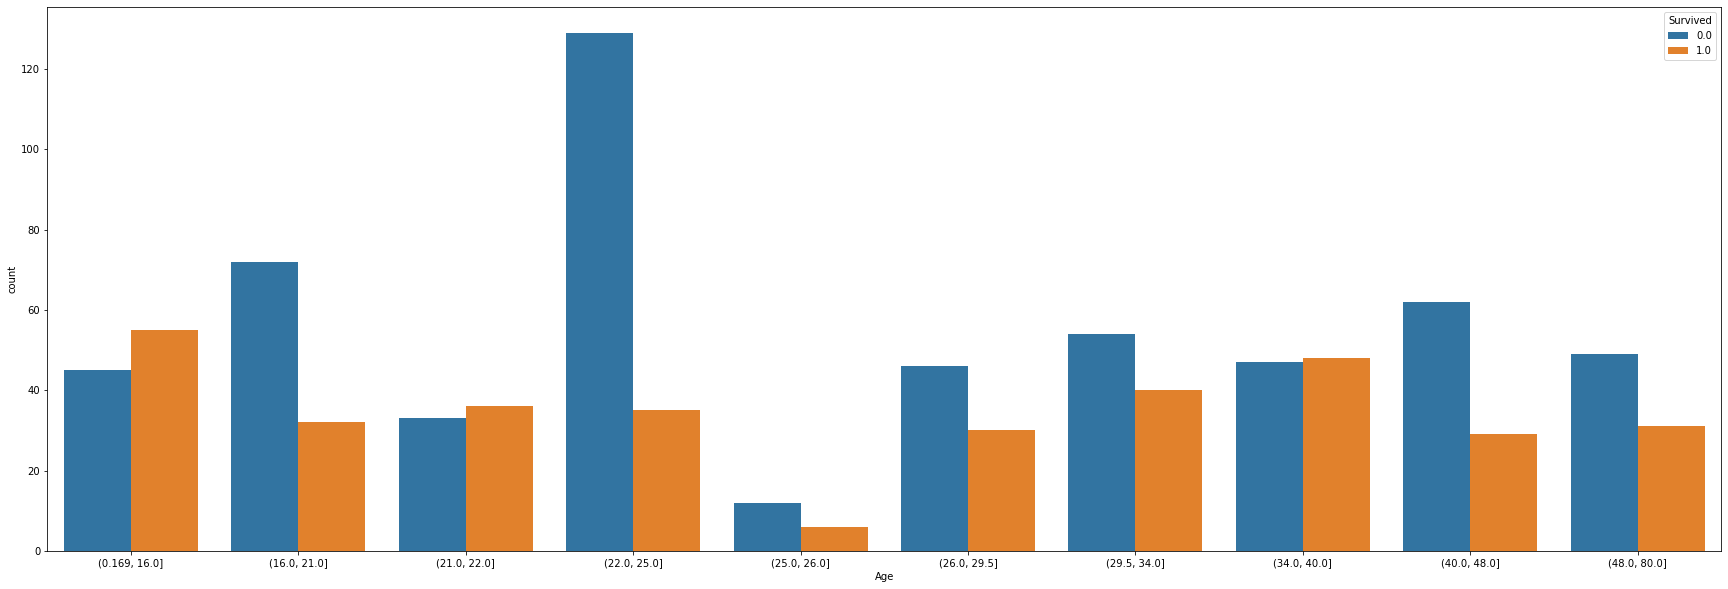

In [959]:
plt.subplots(figsize=(30,10))
sns.countplot(x='Age', hue='Survived', data=train_test)
plt.show()

### Family Size

In [960]:
train_test['FamilySize'] = 1 + train_test['SibSp'] + train_test['Parch']
conditions = [(train_test['FamilySize'] == 1), 
((train_test['FamilySize'] > 1) & (train_test['FamilySize'] < 5)),
((train_test['FamilySize'] > 4) & (train_test['FamilySize'] < 7)),
(train_test['FamilySize'] > 6)]
values = ['Alone', 'Small', 'Medium', 'Large']
train_test['FamilySizeGroup'] = np.select(conditions, values)

### Ticket Frequency

In [961]:
train_test['Ticket_Frequency'] = train_test.groupby('Ticket')['Ticket'].transform('count')

### Title

In [962]:
train_test['Title'] = train_test['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

In [963]:
train_test['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [964]:
train_test['Married'] = 0
train_test['Married'].loc[train_test['Title'] == 'Mrs'] = 1
train_test['Title'] = train_test['Title'].replace(['Mrs', 'Miss', 'Mme', 'Ms', 'Lady', 'Mlle', 'the Countess', 'Dona'], 'Mrs/Miss')
train_test['Title'] = train_test['Title'].replace(['Don', 'Rev', 'Dr', 'Major', 'Sir', 'Col', 'Capt', 'Jonkheer'], 'Special Title')

In [965]:
train, test = separate_df(train_test)

In [966]:
test.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Ticket,FamilySize,FamilySizeGroup,Ticket_Frequency,Title,Married
891,"(34.0, 40.0]",Q,"(7.57, 7.854]","Kelly, Mr. James",0,892,3,male,0,330911,1,Alone,1,Mr,0
892,"(40.0, 48.0]",S,"(-0.001, 7.57]","Wilkes, Mrs. James (Ellen Needs)",0,893,3,female,1,363272,2,Small,1,Mrs/Miss,1
893,"(48.0, 80.0]",Q,"(8.05, 10.5]","Myles, Mr. Thomas Francis",0,894,2,male,0,240276,1,Alone,1,Mr,0
894,"(26.0, 29.5]",S,"(8.05, 10.5]","Wirz, Mr. Albert",0,895,3,male,0,315154,1,Alone,1,Mr,0
895,"(21.0, 22.0]",S,"(10.5, 14.454]","Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,896,3,female,1,3101298,3,Small,2,Mrs/Miss,1


In [967]:
train.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,FamilySize,FamilySizeGroup,Ticket_Frequency,Title,Married
0,"(21.0, 22.0]",S,"(-0.001, 7.57]","Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,2,Small,1,Mr,0
1,"(34.0, 40.0]",C,"(41.579, 78.02]","Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,2,Small,2,Mrs/Miss,1
2,"(25.0, 26.0]",S,"(7.854, 8.05]","Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1,Alone,1,Mrs/Miss,0
3,"(34.0, 40.0]",S,"(41.579, 78.02]","Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,2,Small,2,Mrs/Miss,1
4,"(34.0, 40.0]",S,"(7.854, 8.05]","Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1,Alone,1,Mr,0


## Choosing a Model

In [968]:
X = train.drop('Survived', axis=1)
y = train['Survived']

In [969]:
features_remove = ['Name', 'Ticket', 'PassengerId']
X.drop(features_remove, axis=1, inplace=True)
X.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,FamilySize,FamilySizeGroup,Ticket_Frequency,Title,Married
0,"(21.0, 22.0]",S,"(-0.001, 7.57]",0,3,male,1,2,Small,1,Mr,0
1,"(34.0, 40.0]",C,"(41.579, 78.02]",0,1,female,1,2,Small,2,Mrs/Miss,1
2,"(25.0, 26.0]",S,"(7.854, 8.05]",0,3,female,0,1,Alone,1,Mrs/Miss,0
3,"(34.0, 40.0]",S,"(41.579, 78.02]",0,1,female,1,2,Small,2,Mrs/Miss,1
4,"(34.0, 40.0]",S,"(7.854, 8.05]",0,3,male,0,1,Alone,1,Mr,0


In [970]:
non_numeric_transformer = Pipeline(steps=[('ordinal', OrdinalEncoder())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [971]:
non_numerical_features = ['Age', 'Fare']
categorical_features = ['Embarked', 'Sex', 'Title', 'Pclass','FamilySizeGroup']

In [972]:
preprocessor = ColumnTransformer(transformers=[('num', non_numeric_transformer, non_numerical_features),('cat', categorical_transformer, categorical_features)])

In [973]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [974]:
SEED=123
lr = LogisticRegression()
knn = KNN()
dt = DecisionTreeClassifier(random_state=SEED)
gaussian_nb= GaussianNB()
randomforest=RandomForestClassifier(random_state=SEED)
xgb = XGBClassifier(verbosity = 0)
# Define a list called classifier that contains the tuples (classifier_name, classifier)
classifiers = [('Logistic Regression', lr),('K Nearest Neighbours', knn),('Classification Tree', dt),('Gaussian Naive Bayes', gaussian_nb),('Random Forest', randomforest), ('XGBoost', xgb)]

In [975]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('ordinal',
                                                  OrdinalEncoder())]),
                                 ['Age', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Embarked', 'Sex', 'Title', 'Pclass',
                                  'FamilySizeGroup'])])

In [976]:
for cls_name, clf in classifiers:
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', clf)])
    pipe.fit(X_train, y_train)
    accuracies = cross_val_score(pipe, X = X_train, y = y_train, cv = 10)
    print(cls_name + " Accuracy: {:.2f} %".format(accuracies.mean()*100))
    print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Logistic Regression Accuracy: 81.85 %
Standard Deviation: 3.83 %
K Nearest Neighbours Accuracy: 79.02 %
Standard Deviation: 4.86 %
Classification Tree Accuracy: 78.56 %
Standard Deviation: 4.77 %
Gaussian Naive Bayes Accuracy: 80.20 %
Standard Deviation: 3.77 %
Random Forest Accuracy: 79.01 %
Standard Deviation: 4.16 %
XGBoost Accuracy: 79.61 %
Standard Deviation: 4.13 %


In [977]:
params = {
        'xgb__min_child_weight': [1, 5, 10],
        'xgb__gamma': [0.5, 1, 1.5, 2, 5],
        'xgb__subsample': [0.6, 0.8, 1.0],
        'xgb__colsample_bytree': [0.6, 0.8, 1.0],
        'xgb__max_depth': [3, 4, 5]
        }
""" params = {
        'lr__solver': ['liblinear', 'lbfgs', 'newton-cg'],
        'lr__penalty': ['l2'],
        'lr__C': [1000, 100,10, 1.0, 0.1, 0.01, 0.001, 0.0001]
        } """

" params = {\n        'lr__solver': ['liblinear', 'lbfgs', 'newton-cg'],\n        'lr__penalty': ['l2'],\n        'lr__C': [1000, 100,10, 1.0, 0.1, 0.01, 0.001, 0.0001]\n        } "

In [979]:
pipe = Pipeline(steps=[('preprocessor', preprocessor), ('xgb', xgb)])
pipe.fit(X_train, y_train)
grid_search = GridSearchCV(pipe,
                           params,
                           n_jobs = -1, scoring='roc_auc')
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 87.37 %
Best Parameters: {'xgb__colsample_bytree': 1.0, 'xgb__gamma': 1, 'xgb__max_depth': 3, 'xgb__min_child_weight': 1, 'xgb__subsample': 1.0}


In [980]:
xgb_upd = XGBClassifier(colsample_bytree=1.0, gamma=1, max_depth=3, min_child_weight=1, subsample=1)
pipe = Pipeline(steps=[('preprocessor', preprocessor), ('xgb', xgb_upd)])
""" lr_upd = LogisticRegression(C=1, penalty='l2', solver='lbfgs')
pipe = Pipeline(steps=[('preprocessor', preprocessor), ('lr', lr_upd)])  """
pipe.fit(X,y)
passengers=test.PassengerId
test.drop(features_remove, axis=1, inplace=True)
y_final_pred = pipe.predict(test).astype(int)

In [981]:
output = pd.DataFrame({'PassengerId': passengers, 'Survived': y_final_pred})
output.to_csv('submission.csv', index=False)